# RandomForests for the Prediction of Wine Quality

## Decision Trees and RandomForests
Decision trees are a method of supervised learning which have been widely used in the process of prediction. Regression trees are used in place of classification trees when the variable to be predicted is continuous, not categorical. Terminal nodes obtain a value that is the mean response of observations falling in that region, thereby handling unseen data observations in that region by making its prediction with a mean value.

### Why use them?
Decision trees allow for a quick and easy interpretation of how the process of prediction works - often valuable when explanation of how your algorithm works is a necessity. A RandomForest is an ensemble of decision trees that makes using of bagging - reduce the variance of a large number of "complex" decision trees with low bias. RandomForests require no normalization of inputs as it is based on recursive partitioning which allows them to be implemented quickly and easily to great effect. RandomForests also allow the user to find which features are "more important" in the dataset, which can then be selected if we need to save processing time or power.

## Importing Libraries
This tutorial is making use of the scikit learn library's implementation of RandomForests. Plotting is done via matplotlib and a rough implementation of RandomForests is implemented from scratch to show how splits are done and how outputs are calculated.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import pandas as pd
import numpy as np
import csv
import urllib2
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.tree import export_graphviz

import pylab
%matplotlib inline
from collections import Counter

## RandomForest Overview
For a classification problem, a decision tree is grown that can classify an object given an input vector. A RandomForest basically grows multiple trees, and to classify a new object, it passes that input vector through the entire "forest" (each individual tree). Each tree in the forest classifies the object as belonging to a particular class, and we say that the tree "votes" for that class. For each input vector (row of data), the forest will then choose the most popular vote of all of the trees in the forest. The entire training data is sampled with replacement and used to build each individual tree.

### Same dataset for all trees, same classification trees? 
Since we are sampling the entire dataset, we need to create trees that will classify each input vector differently. This is done by RandomForests in the following way - 
1. If there are M input variables, a constant number m << M is specified such that at each node, random m variables (out of M) are selected and the best split on these m is used to split the node. The value of m is held constant for the entire forest, and is generally taken such that m is the square root of M.
2. Each tree is grown to the largest extent possible. There is no pruning.

In Brieman's original paper on RandomForests, it was shown that the forest error rate depends on two things:

a) The correlation between any two trees in the forest. Increasing the correlation increases the forest error rate.
b) The strength of each individual tree in the forest. A tree with a low error rate is a strong classifier. Increasing the strength of the individual trees decreases the forest error rate.

Reducing m reduces both the correlation and the strength. Increasing it increases both. Somewhere in between is an "optimal" range of m - usually quite wide. 

![title](RandomForest.jpg)


### Out of Bag Error Estimate
Each tree is constructed using a different bootstrap sample from the original data. About one-third of the cases are left out of the bootstrap sample and not used in the construction of the kth tree.

"Put each case left out in the construction of the kth tree down the kth tree to get a classification. In this way, a test set classification is obtained for each case in about one-third of the trees. At the end of the run, take j to be the class that got most of the votes every time case n was oob. The proportion of times that j is not equal to the true class of n averaged over all cases is the oob error estimate." (Brieman 2001)

### Loading Data and Inspecting
This tutorial will go about using RandomForests by using a dataset about the quality of wine [Cortez et al., 2009] and emphasize on important features.  RandomForests are extremely useful when there are a multitude of features and we can visually see which ones are most important when it comes to our model. There are two datasets - one which had quality for red wine and the other for white wine.

The data is available at https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv and https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv. You can download the data into the same folder as this python notebook and run the following cells - or use the appropriate path. Let us see the head of the data and get a brief idea of the wine quality distribution.



In [3]:
whiteDf = pd.read_csv('winequality-white.csv')
redDf = pd.read_csv('winequality-red.csv')
whiteDf.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Quality        3      4       5       6      7      8    9
White Wine  20.0  163.0  1457.0  2198.0  880.0  175.0  5.0
Red Wine    10.0   53.0   681.0   638.0  199.0   18.0  NaN


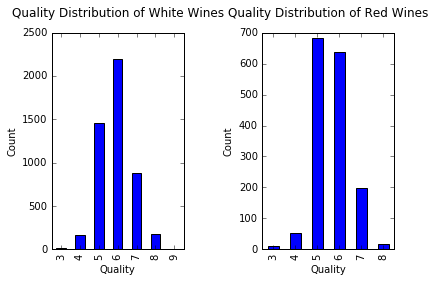

In [4]:
whiteWineGroup = whiteDf.groupby('quality')
whiteFreq = whiteWineGroup.size()

redWineGroup = redDf.groupby('quality')
redFreq = redWineGroup.size()

totalFreq = [whiteFreq,redFreq]
totalFreqdf = pd.DataFrame(totalFreq)

totalFreqdf.columns.names = ['Quality']
totalFreqdf = totalFreqdf.rename(index={1: 'Red Wine', 0 :'White Wine'})
print totalFreqdf

fig = plt.figure()

ax1 = fig.add_subplot(121)
whiteFreq.plot(kind='bar')
ttl = ax1.title
ttl.set_position([.5, 1.05])
pylab.xlabel('Quality')
pylab.ylabel('Count')
pylab.title('Quality Distribution of White Wines')

ax2 = fig.add_subplot(122)
redFreq.plot(kind='bar')
tt2 = ax2.title
tt2.set_position([.5, 1.05])
pylab.xlabel('Quality')
pylab.ylabel('Count')
pylab.title('Quality Distribution of Red Wines')
fig.tight_layout()
plt.show()

We can see a majority of wines have quality = 6. There are 20 very bad wines (quality = 3) and 5 excellent ones. 
We now map the qualities into three factors - Good, Bad and normal for both white and red wines.

In [5]:
def qualityLevels(q):
    if q<6:
        return "Bad"
    elif q >6:
        return "Good"
    else:
        return "Normal"
    
whiteDf["quality"] = whiteDf['quality'].map(qualityLevels)
redDf['quality'] = redDf['quality'].map(qualityLevels)

### Simulating a RandomForest
The following code creates a decision tree classifier which creates predictions based on subsets of columns of the entire data. All of the predictions of each tree are then combined to check which value occurs the most for each row, and thus creating a randomforest!


In [6]:
X = whiteDf.drop("quality", axis=1)
Y = whiteDf["quality"]

def treeOutput(X,y):
    """ Creates a tree with a fixed split for train and test and predicts based on the input
            Args: 
                X (df) : Randomly sampled df with only 70% of columns of actual df
                y (vector) : output labels
            Output: 
                (yhat) : predicted output labwls
        """
    np.random.seed(10)
    randomTree = tree.DecisionTreeClassifier()
    msk = np.random.rand(len(X)) < 0.7
    errors = 0
    errorRate = 0
    X0 = X[msk]
    y0 = y[msk]
    X1 = X[~msk]
    randomTree.fit(X0,y0)
    yhat = randomTree.predict(X1)
    return yhat

def treecount(n):
    """ Creates n trees using the treeOutput function and selects the best occuring value for each row of the test DF
            Args:
                n (int) : Number of input trees
            Output:
                Error rate for our randomforest
    """
    outputList = []
    for i in range(1,n):
        outputList.append(treeOutput(X.sample(frac = 0.7,replace = True, axis = 1), Y)) #Get a list of all predictions

    df = pd.DataFrame(outputList) #Convert it into a df
    finalOutput = []
    for column in df:             # This finds the most commonly occuring value for each column of the DF (best prediction!)
        z = df[column]
        highest = 0
        counts = z.value_counts()
        maxcount = z.value_counts().index.tolist()
        finalOutput.append(maxcount[0]) #Appends the best prediction

    np.random.seed(10)
    msk = np.random.rand(len(X)) < 0.7
    y1 = Y[~msk]

    return np.mean(y1 != finalOutput) # Returns the error rate
  
print ("The error for 5 trees is ", treecount(5))
print ("The error for 50 trees is ", treecount(50))



('The error for 5 trees is ', 0.34810126582278483)
('The error for 50 trees is ', 0.29465541490857944)


### Feature Selection in RandomForests
For now, let us see which features have the most impact on wine quality for white and red wine. We will fit a randomForest classifier to our data and use the feature_importances_ attribute to find out the ranking of predictors. 

In [7]:
def featureSel(wineDf):
    """ Tells us the most important features of the DF
            Args:
                wineDf (df) : Dataframe for which we want the important features
            Output:
                List of features in decreasing order of importance
                """
    X = wineDf.drop("quality", axis=1)
    Y = wineDf["quality"]
    rf = RandomForestClassifier(n_jobs = 10)#,max_features=5)
    rf.fit(X, Y)
    names = list(X.columns.values)
    return sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

print ("Important features for White Wine")
print(featureSel(whiteDf))
print ("Important features for Red Wine")
print(featureSel(redDf))

Important features for White Wine
[(0.1193, 'alcohol'), (0.1165, 'density'), (0.0981, 'volatile acidity'), (0.0935, 'free sulfur dioxide'), (0.0846, 'total sulfur dioxide'), (0.0846, 'residual sugar'), (0.0829, 'chlorides'), (0.0828, 'pH'), (0.0827, 'citric acid'), (0.0791, 'sulphates'), (0.0759, 'fixed acidity')]
Important features for Red Wine
[(0.1507, 'alcohol'), (0.1233, 'sulphates'), (0.1089, 'total sulfur dioxide'), (0.1029, 'volatile acidity'), (0.0901, 'density'), (0.0788, 'chlorides'), (0.0754, 'citric acid'), (0.0702, 'pH'), (0.0674, 'residual sugar'), (0.0672, 'free sulfur dioxide'), (0.0651, 'fixed acidity')]


This uses Gini impurity to split on each node. Some problems that arise in this is that when the dataset has two or more highly correlated variables, the Gini split will give a lot of importance to the first one, while giving very low importance to the second one. This is due to the fact that any one of the two variables can be used for accurate predictions on the model - hence giving the first one high and the second one not being useful. While this may not be problematic for our current predictions, it may result in some incorrect conclusions as to which factors are important. 


In [8]:
whiteCorr = whiteDf.drop("quality", axis=1)
redCorr = redDf.drop("quality",axis = 1)
whiteCorr.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,-0.022697,0.289181,0.089021,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881
volatile acidity,-0.022697,1.000000,-0.149472,0.064286,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718
citric acid,0.289181,-0.149472,1.000000,0.094212,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729
residual sugar,0.089021,0.064286,0.094212,1.000000,0.088685,0.299098,0.401439,0.838966,-0.194133,-0.026664,-0.450631
chlorides,0.023086,0.070512,0.114364,0.088685,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189
free sulfur dioxide,-0.049396,-0.097012,0.094077,0.299098,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104
total sulfur dioxide,0.091070,0.089261,0.121131,0.401439,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892
density,0.265331,0.027114,0.149503,0.838966,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138
pH,-0.425858,-0.031915,-0.163748,-0.194133,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432
sulphates,-0.017143,-0.035728,0.062331,-0.026664,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433


To visualize the above matrix, we can plot it using matplotlib's library.

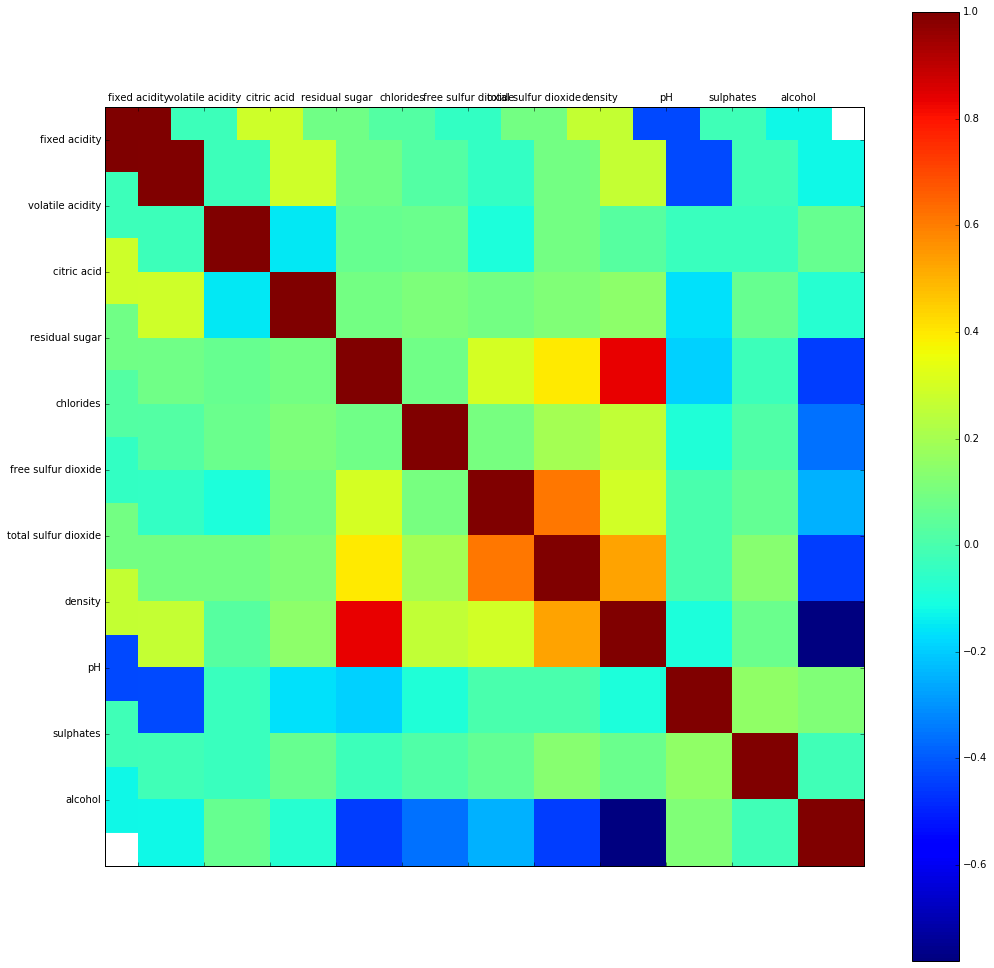

In [9]:
# Code from http://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
# answered Jul 13 '15 at 13:10 by Apogentus. 

def plot_corr(df,size=10):
    """Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot
        """

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(17, 17))
    ax.matshow(corr)
    colorLegend = ax.pcolor(corr);
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    fig.colorbar(colorLegend)
    
plot_corr(whiteCorr)

Autocorrelation is a problem for other ML algorithms as well.Another way of ranking features is by using Mean Decrease Accuracy - i.e. find out how much each individual feature impacts the accuracy of our model. 

## Implementing a RF using Scikit Learn
The below code is the implemntation of a randomforest using sklearn. We are tuning 2 parameters, number of trees and the m (number of features to split on at each node) using grid search and the CV code from the third assignment.

In [10]:
import math

class ModelSelector:
    """ A class that performs model selection. 
        Attributes:
            blocks (list) : list of lists of indices of each block used for k-fold cross validation, e.g. blocks[i] 
            gives the indices of the examples in the ith block 
            test_block (list) : list of indices of the test block that used only for reporting results
            
    """
    def __init__(self, X, y, P, k):
        """ Initialize the model selection with data and split into train/valid/test sets. Split the permutation into blocks 
            and save the block indices as an attribute to the model. 
            Args:
                X (array_like) : array of features for the datapoints
                y (vector) : 1D numpy array containing the output labels for the datapoints
                P (vector) : 1D numpy array containing a random permutation of the datapoints
                k (int) : number of folds
                niters (int) : number of iterations to train for
        """
        self.X = X
        self.y = y
        self.P = P
        self.k = k
        pSplit = np.array_split(self.P, k+1)
        self.blocks = list(pSplit[:-1])
        self.yhat = 0
        self.y1 = 0
        self.test_block = list(pSplit[-1])

    def cross_validation(self, ntree, m  ):
        """ Given the permutation P in the class, evaluate the SVM using k-fold cross validation for the given parameters 
            over the permutation
            Args: 
                m (int) : number of features split at each node
                ntree (int) : number of trees
            Output: 
                (float) : the cross validated error rate
        """
        avgerr = 0
        errorRate = 0
        for i in range(self.k):
            ilist = []
            for index,j in enumerate(self.blocks):
                 if index!= i:
                    ilist.extend(j)

            X0 = self.X[ilist]
            y0 = self.y[ilist]
            
            X1 = self.X[self.blocks[i]]
            y1 = self.y[self.blocks[i]] 
            rf = RandomForestClassifier(n_estimators = ntree,max_features = m,class_weight = "auto",oob_score = True)
            rf = rf.fit(X0,y0)
            yhat = rf.predict(X1)
            
            
            errors = np.sum(yhat!=y1)
            errorRate += errors/(float(len(yhat)))
                   
        return rf.oob_score_
    
    def grid_search(self, ntree, m ):
        """ Given a list of parameters for ntree, perform a grid search using
            k-wise cross validation to select the best parameters. 
            Args:  
                ntree (list) : list of number of trees
            Output: 
                (ntree) : best found parameter
        """
        merr = 100
        moob = 0
        best = 0
        for i in ntree:
            for j in m:
                e = self.cross_validation(i,j)
                if e > moob:
                    moob = e
                    best = (i,j)
        return (best)       
        pass
    
    def varianceCalc(self):
        """ Uses predicted values and actual test labels to
            calculate the variance by using one hot encoding and the probabilities of each class
            Output: 
                (var) : variance of the randomForest
        """
        y1 = self.y1
        yhat = self.yhat
        missingPreds = set(y1) - set(yhat) #Get values that are in the output set, but not in our predictions
        oneHotPred = pd.get_dummies(yhat)
        oneHotY = pd.get_dummies(y1)

        for item in missingPreds:
            oneHotPred[item] = 0.0

        oneHotPred = oneHotPred.reindex_axis(sorted(oneHotPred.columns), axis=1) #Sort df 
        oneHotY = oneHotY.reset_index(drop = True)

        probabilities = oneHotPred.apply(np.mean,axis = 0)

        sqVal = (probabilities - oneHotY)
        rowSums = np.sum(abs(sqVal),axis = 1)
        totalVar =np.sum(rowSums**2)/len(yhat)
        
        return (totalVar)
        
    def test(self, ntree, m):
        """ Given parameters, calculate the error rate of the test data given the rest of the data. 
            Args: 
                ntree (int) : number of trees
                m (int) : Subset of features to calc on split
            Output: 
                (err, svm) : tuple of the error rate of the rf on the test data and the learned model
        """
        ilist = []
        err = 0
        for j in (self.blocks):
            ilist.extend(j)
             
        X0 = self.X[ilist]
        y0 = self.y[ilist]
        
        X1 = self.X[self.test_block]
        y1 = self.y[self.test_block]
        
        
        rf = RandomForestClassifier(n_estimators = ntree,max_features = m, class_weight = "auto",oob_score=True)
        rf.fit(X0, y0)
        yhat = rf.predict(X1)
        self.yhat = yhat
        self.y1 = y1
        errors = np.sum(yhat!=y1)
        errorRate = errors/(float(len(yhat)))
        return (errorRate,rf)

In [11]:
X0 = np.array(whiteDf.drop("quality", axis=1))
y0 = np.array(whiteDf["quality"])
MS = ModelSelector(X0, y0, np.arange(X0.shape[0]), 3)
ntree,maxFeature = MS.grid_search((10,20,50,100,200),np.arange(1,X0.shape[1]))
print ntree,maxFeature
print MS.test(ntree,maxFeature)
MS.varianceCalc()

C:\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


200 1
(0.4264705882352941, RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False))


1.6130275111703714

The reason that this model performs badly is because of the probability distribution of classes in our input dataset. When we split the initial dataset into training/test/validation for CV, the small size of the data results in the model not performing well on unseen data that exists in the test set but not in the others (OOB error warning). This combined with the correlation of features results in a much lower accuracy(60%~) as compared to the quick construction of the RandomForest that we have implemented in the beginning (75%~) accuracy. 
Domain specific knowledge about wine will also allow us to integrate newer data sources into the model and allow for better features which can lead to more accurate predictions!

## Summary
This tutorial highlights key factors of RandomForests - their ease of implementation as well as how we can find important features from our dataset with little domain knowledge. The reader is encouraged to attempt the same predictions with the dataset for red wines and observe the differences in prediction accuracy by varying the parameters in the grid search.


###### References
1. Richard Maclin and David Opitz. An Empirical Evaluation of Bagging and Boosting, The Fourteenth National Conference on Artificial Intelligence, Providence Rhode Island 1997 AAAI Press - http://www.cs.uu.nl/docs/vakken/sl/additional_course_material/Maclin_Opitz_-_An_Empirical_Evaluation_of_Bagging_and_Boosting.pdf
2. L. Breiman. Bagging predictors. Machine Learning, 24 (2):123–140, 1996. - http://statistics.berkeley.edu/sites/default/files/tech-reports/421.pdf
3. L. Breiman. Random forests. Machine Learning, 45(1): 5–32, 2001. - https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf
4. DataDive. 2014. Diving Into Data. [ONLINE] Available at: http://blog.datadive.net/selecting-good-features-part-iii-random-forests/. [Accessed 19 October 2016].
5. https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm